In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, validation_curve, learning_curve, cross_val_score

In [3]:
# Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# The second parameter determines whether to apply feature scaling.
models = {
    "Decision Tree": (DecisionTreeClassifier(max_depth=1), False),
    "KNN": (KNeighborsClassifier(n_neighbors=1), True),
    "Naive Bayes": (GaussianNB(priors=[0.99, 0.01]), False),
    "SVM": (SVC(C=10, probability=True), True),
    "Logistic Regression": (LogisticRegression(C=20, max_iter=10000), True),
}

In [4]:
from sklearn.datasets import load_breast_cancer

cancer = load_breast_cancer()
X = cancer.data
y = cancer.target

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Box plot comparisons

#### Steps  
   - Use `cross_val_score()` with a chosen scoring metric (e.g., `'accuracy'`, `'f1'`, `'roc_auc'`).  
   - Run cross-validation (e.g., 5-fold) to obtain scores for each fold.  
   - Collect scores from all models into a tidy format.  
   - Use a `seaborn` box plot to compare model performance distribution.  

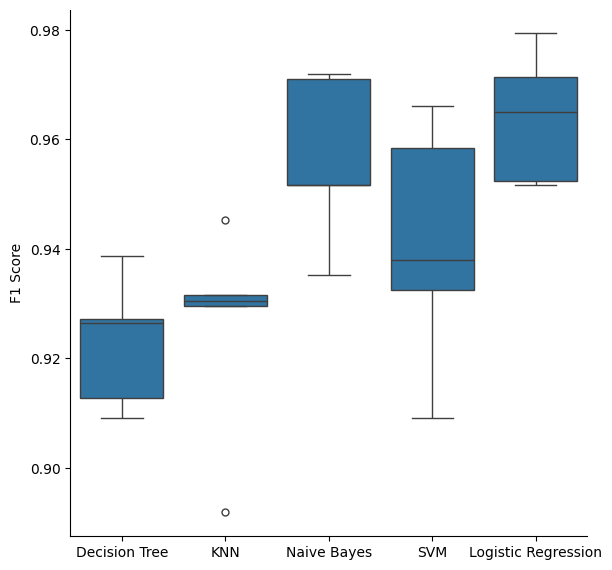

In [7]:
# Box plots for F1 scores
results = []

for name, (model, _) in models.items():
    scores = cross_val_score(model, X, y, cv=5, scoring='f1')
    for score in scores:
        results.append({'Model': name, 'F1 Score': score})

df_results = pd.DataFrame(results)
g = sns.catplot(data=df_results, kind="box", x='Model', y='F1 Score', height=6, aspect=1)
g.set_axis_labels("", "F1 Score");

### ROC curve comparisons 

#### Steps  
   - Use `predict_proba()` to get class probabilities for ROC analysis.
        - For SVM, set `probability=True` to enable probability prediction.
   - Compute `fpr`, `tpr`, and thresholds using `roc_curve()`.
   - Calculate `roc_auc_score()` for the AUC metric.
   - Plot each model's ROC curve on a single graph.
   - Add a baseline "random classifier" line for reference.

In [8]:
roc_data = []
for name, (model, use_scaled) in models.items():
    X_tr = X_train_scaled if use_scaled else X_train
    X_te = X_test_scaled if use_scaled else X_test

    model.fit(X_tr, y_train)
    y_prob = model.predict_proba(X_te)[:, 1]

    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    auc = roc_auc_score(y_test, y_prob)

    df = pd.DataFrame({
        'False Positive Rate': fpr,
        'True Positive Rate': tpr,
        'Threshold': thresholds,
        'Model': f"{name} (AUC = {auc:.4f})"
    })
    roc_data.append(df)


roc_df = pd.concat(roc_data, ignore_index=True)

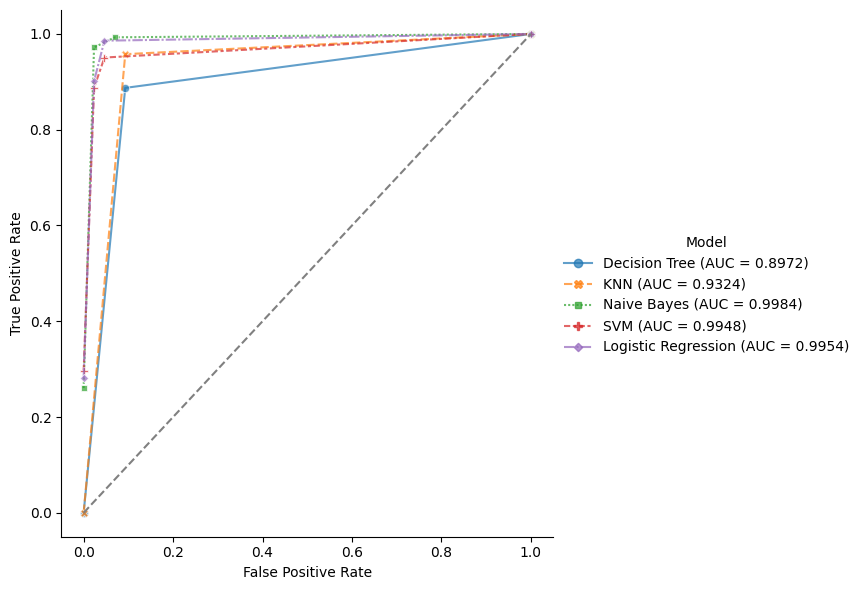

In [9]:
g = sns.relplot(
    data=roc_df,
    kind="line",
    x='False Positive Rate',
    y='True Positive Rate',
    hue='Model',
    style='Model',
    height=6,
    aspect=1,
    markers=True,
    errorbar=None,
    alpha=0.7
)

ax = g.ax  
ax.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Classifier');


## Underfitting, Overfitting, and Good fit

When training machine learning models, one of the key goals is to **generalize well** — meaning the model performs well not just on the training data, but also on unseen (test) data.

There are three common scenarios:

### Underfitting

- **What it is**: The model is too simple to capture the underlying patterns in the data.
- **Symptoms**:
  - Poor performance on both training and test sets.
  - Low training accuracy.
  - Training and test accuracy are similarly low.
  - Adding more data doesn't improve performance.
- **Common causes**:
  - Model is too basic (e.g., linear for nonlinear data).
  - Model is not properly optimized (e.g., solver didn't converge, not enough estimators in ensemble models).
  - Too much regularization.
  - Irrelevant or missing features.
  - Inadequate model architecture or hyperparameters.

### Overfitting

- **What it is**: The model learns not only the true patterns but also the noise in the training data.
- **Symptoms**:
  - High training accuracy.
  - Low test/validation accuracy.
  - Large gap between training and test accuracy.
  - Model performs worse as complexity increases.
- **Common causes**:
  - Model is too complex.
  - Not enough data.
  - Lack of regularization.
  - Too many features relative to sample size.
  - Overtraining (e.g., too many boosting rounds, high `max_iter`).

### Good fit (a.k.a. generalization)

- **What it is**: The model captures the important patterns in the training data and performs well on unseen data.
- **Symptoms**:
  - High training accuracy.
  - High [and similar to training] test accuracy.
  - Small gap between training and test performance.
  - Performance improves (or remains stable) with more data.



## Hyperparameter sensitivity via Cross-Validation

We use cross-validation to evaluate model performance across different values of a hyperparameter.

Each box shows the distribution of accuracy scores over 5 folds for a given setting. This lets us assess:

- **Overfitting**: If accuracy is high, but the scores are unstable (wide spread), it may indicate overfitting.
- **Underfitting**: If accuracy is consistently low across folds, the model may be too simple.
- **Good generalization**: Look for the region where accuracy is relatively high and the variance across folds is low — this indicates a stable and well-generalizing model.

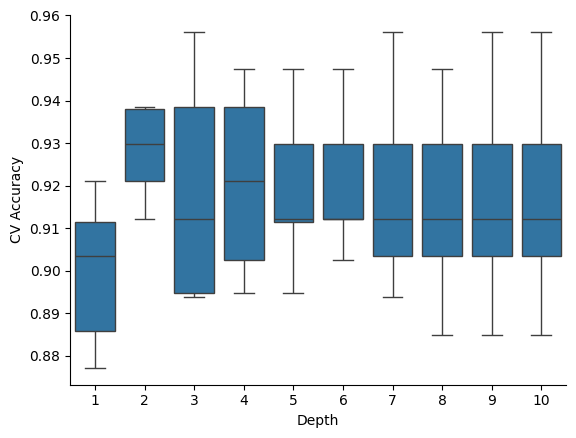

In [10]:
# Run CV for different depths
cv_results = []
for d in range(1, 11):
    scores = cross_val_score(
        DecisionTreeClassifier(max_depth=d, random_state=42),
        X, y, cv=5, scoring="accuracy"
    )
    for s in scores:
        cv_results.append({"Depth": d, "CV Accuracy": s})

cv_df = pd.DataFrame(cv_results)
sns.boxplot(data=cv_df, x="Depth", y="CV Accuracy")
sns.despine()

### Interpretation

- **Depth = 1** shows relatively **low median accuracy** and wider spread, indicating **underfitting** — the model is too simple to capture the structure of the data.

- **Depths = 2** shows a noticeable increase in **both median accuracy and consistency** (tighter spread), suggesting this is a good range for **balanced generalization and low variance**.

- **Depths = 3 to 10** maintain high accuracy in some folds, but with a **larger spread** and more outliers — this indicates **increased risk of overfitting**, where performance may vary significantly depending on the data split. In real-world applications, this kind of variance means unreliable predictions.

Overall, **depth = 2** appears to be a **sweet spot**, offering high accuracy with stable generalization across folds. 

## Validation curve

We use a validation curve to evaluate how model performance changes with increasing complexity — in this case, by varying the `max_depth` of a Decision Tree classifier.

In the plot:

- The **training accuracy** line shows how well the model fits the training data.
- The **validation accuracy** line estimates how well the model generalizes to unseen data (via cross-validation).

This helps us assess:

- **Underfitting**: If both training and validation accuracy are low at shallow depths, the model is too simple to capture patterns.
- **Overfitting**: If training accuracy is very high but validation accuracy drops, the model is likely memorizing the training data.
- **Good generalization**: The ideal depth is where validation accuracy peaks and is close to training accuracy.


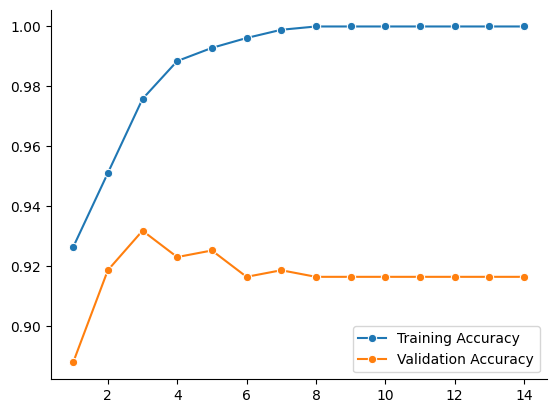

In [11]:
depth_range = np.arange(1, 15)
train_scores, val_scores = validation_curve(
    DecisionTreeClassifier(random_state=42),
    X_train, y_train,
    param_name="max_depth",
    param_range=depth_range,
    cv=5,
    scoring="accuracy"
)

train_mean = train_scores.mean(axis=1)
val_mean = val_scores.mean(axis=1)


sns.lineplot(x=depth_range, y=train_mean, label="Training Accuracy", marker="o")
sns.lineplot(x=depth_range, y=val_mean, label="Validation Accuracy", marker="o")
sns.despine()

### Interpretation

#### Early region (max_depth ≈ 1 to 2)
- Training accuracy increases from ~0.93 to ~0.98, and validation accuracy rises from ~0.89 to ~0.93.
- This region shows **reduced underfitting** — the model is gaining expressiveness and capturing more structure in the data.

#### Middle region (max_depth ≈ 3 to 6)
- Training accuracy nears perfection (~0.99), while validation accuracy peaks (~0.93) and then begins to slightly decline.
- This indicates the **transition zone** — the model fits the training data extremely well, but generalization may be starting to suffer.

#### High max_depth (max_depth ≈ 7+)
- Training accuracy reaches and stays at **1.0**, indicating complete memorization of the training set.
- Validation accuracy plateaus around **0.916**, with a consistent gap between train and validation scores.
- This is clear evidence of **overfitting** — the model is too complex and no longer generalizes well.


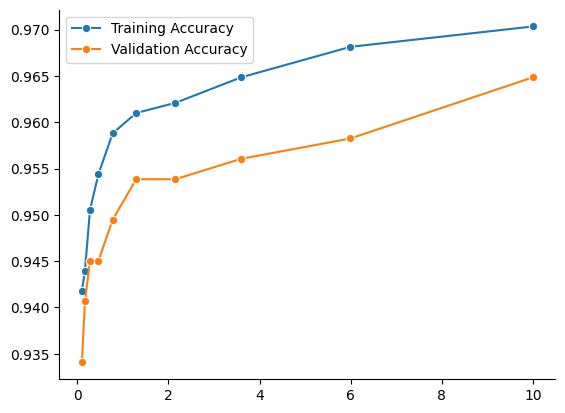

In [12]:
from sklearn.linear_model import LogisticRegression


C_range = np.logspace(-1, 1, 10)

train_scores, val_scores = validation_curve(
    LogisticRegression(penalty='l2', solver='liblinear', max_iter=1000),
    X_train, y_train,
    param_name="C",
    param_range=C_range,
    cv=5,
    scoring="accuracy"
)

train_mean = train_scores.mean(axis=1)
val_mean = val_scores.mean(axis=1)

sns.lineplot(x=C_range, y=train_mean, label="Training Accuracy", marker="o")
sns.lineplot(x=C_range, y=val_mean, label="Validation Accuracy", marker="o")
sns.despine()

### Interpretation

#### Early region (C ≈ 0.1 to 1.0)
- Training accuracy ranges from 0.94 to 0.95, while validation accuracy stays lower, around 0.93 to 0.94.
- This suggests **mild underfitting** — the model is slightly too regularized to capture the full complexity of the data.

#### Middle region (C ≈ 1.0 to 3.0)
- Training accuracy rises steadily to ~0.961, and validation accuracy improves to ~0.954.
- This is likely the **generalization sweet spot**, where the model performs well on both train and validation data with minimal gap.

#### High C (C ≈ 10)
- Training accuracy reaches ~0.970, and validation accuracy peaks at ~0.965.
- The small gap between train and validation suggests **good generalization** continues, though we are nearing the point where **mild overfitting** could begin if `C` increases further.


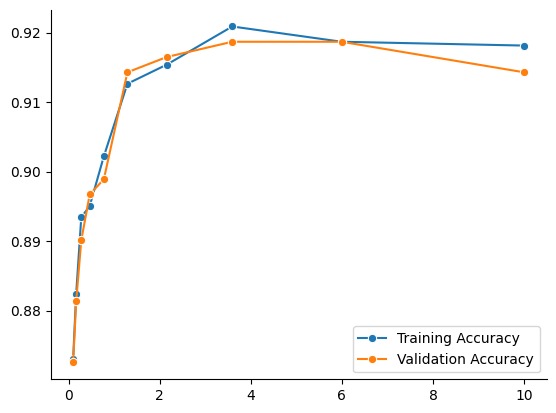

In [13]:
from sklearn.svm import SVC


C_range = np.logspace(-1, 1, 10)

train_scores, val_scores = validation_curve(
    SVC(kernel='rbf', gamma='scale', random_state=42),
    X_train, y_train,
    param_name="C",
    param_range=C_range,
    cv=5,
    scoring="accuracy"
)


train_mean = train_scores.mean(axis=1)
val_mean = val_scores.mean(axis=1)

sns.lineplot(x=C_range, y=train_mean, label="Training Accuracy", marker="o")
sns.lineplot(x=C_range, y=val_mean, label="Validation Accuracy", marker="o")
sns.despine()


### Interpretation

#### Early region (C ≈ 0.1 to 1.0)
- Both training and validation accuracy are in the high 0.87–0.90 range.
- This indicates **mild underfitting** — the regularization is too strong, and the model is too constrained.

#### Middle region (C ≈ 1.0 to 3.0)
- Validation accuracy peaks around **0.919**, and training accuracy is also high and close.
- This is the **ideal generalization zone** — the model is complex enough to capture patterns but not so complex that it overfits.
- This is likely the **sweet spot for `C`**.

#### High C (C ≈ 10)
- Training accuracy remains high (≈ 0.918), but validation accuracy drops slightly to **0.914**.
- This suggests **mild overfitting** — the model is starting to memorize the training data and generalize slightly worse.


## Learning curve

A learning curve shows how model performance evolves as the amount of training data increases.

In the plot:

- The **training accuracy** line reflects how well the model fits the training data at each subset size.
- The **validation accuracy** line estimates how well the model generalizes, based on cross-validation.

This helps us understand:

- **Overfitting**: If training accuracy is much higher than validation accuracy, the model is too complex and not generalizing well — more data may help.
- **Underfitting**: If both accuracies are low and close together, the model is too simple regardless of data size.
- **Good generalization**: Ideally, training and validation accuracy converge at a high value as data increases — this means the model learns meaningful patterns and generalizes well.

Learning curves are especially useful to decide whether collecting more data is likely to improve performance.

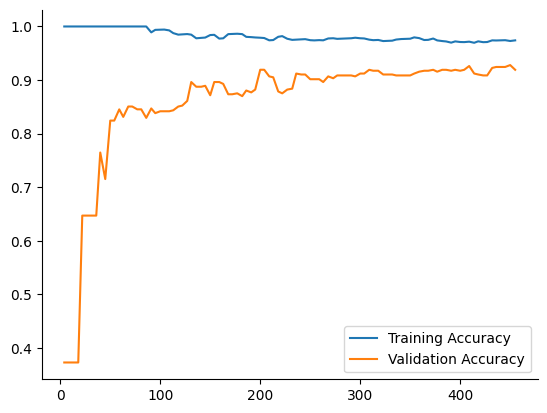

In [14]:
train_sizes, train_scores, val_scores = learning_curve(
    DecisionTreeClassifier(max_depth=3, random_state=42),
    X, y,
    train_sizes=np.linspace(0.01, 1.0, 100),
    cv=5,
    scoring="accuracy"
)

train_mean = train_scores.mean(axis=1)
val_mean = val_scores.mean(axis=1)

sns.lineplot(x=train_sizes, y=train_mean, label="Training Accuracy")
sns.lineplot(x=train_sizes, y=val_mean, label="Validation Accuracy")
sns.despine()

### Is `max_depth=3` a good parameter choice?

Based on the learning curve data:

- **Training accuracy** starts at **1.0** for very small training sets and gradually decreases to about **0.974** as the training size approaches 100%. This is a typical and healthy pattern, suggesting that the model is not overfitting as more data is introduced.
  
- **Validation accuracy** begins very low (~0.37), indicating overfitting on tiny samples, but **rises steadily and stabilizes around 0.92–0.93** as the training set grows. This is a strong indication of **good generalization** at large data sizes.

- The **gap between training and validation accuracy narrows** consistently, and both curves plateau, suggesting that the model has reached its capacity and is not underfitting or overfitting at larger scales.

Together, these trends suggest that `max_depth=3` is a **well-tuned parameter** for this model.


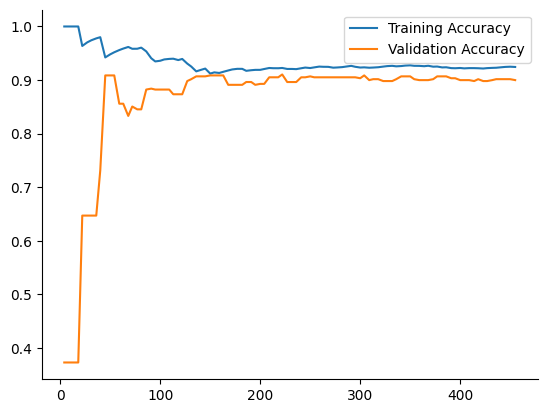

In [15]:
train_sizes, train_scores, val_scores = learning_curve(
    DecisionTreeClassifier(max_depth=1, random_state=42),
    X, y,
    train_sizes=np.linspace(0.01, 1.0, 100),
    cv=5,
    scoring="accuracy"
)

train_mean = train_scores.mean(axis=1)
val_mean = val_scores.mean(axis=1)

sns.lineplot(x=train_sizes, y=train_mean, label="Training Accuracy")
sns.lineplot(x=train_sizes, y=val_mean, label="Validation Accuracy")
sns.despine()

### Is `max_depth=1` a good parameter choice?

The learning curve data suggests that `max_depth=1` is **not an optimal choice**. Here's why:

- **Training accuracy** starts very high (1.0) for small datasets, but quickly drops and stabilizes at around **0.92–0.93**, which is noticeably lower than with deeper trees.
  
- **Validation accuracy**, while improving from very low values (~0.37), **plateaus around 0.90–0.91**, which is lower than what was observed for `max_depth=3` (which reached ~0.92–0.93+).

- The **gap between training and validation accuracy is small**, which might seem good at first — but both scores are **consistently lower** than those achieved by deeper trees. This suggests that the model is **underfitting**: it lacks the capacity to capture the complexity of the data.

Overall, while `max_depth=1` avoids overfitting, it does so at the cost of **too much bias**. The model is overly simplistic, and performance on both training and validation sets confirms it cannot learn rich decision boundaries.


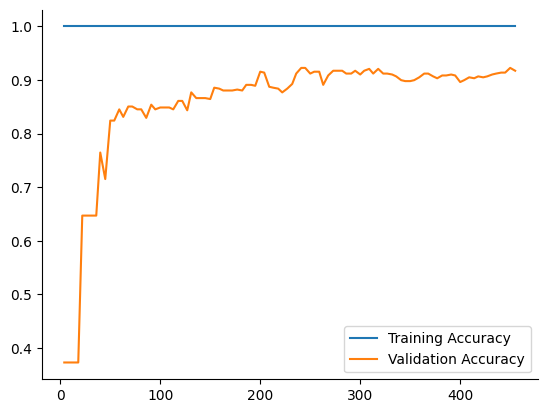

In [16]:
train_sizes, train_scores, val_scores = learning_curve(
    DecisionTreeClassifier(max_depth=10, random_state=42),
    X, y,
    train_sizes=np.linspace(0.01, 1.0, 100),
    cv=5,
    scoring="accuracy"
)

train_mean = train_scores.mean(axis=1)
val_mean = val_scores.mean(axis=1)


sns.lineplot(x=train_sizes, y=train_mean, label="Training Accuracy")
sns.lineplot(x=train_sizes, y=val_mean, label="Validation Accuracy")
sns.despine()

### Is `max_depth=10` a good parameter choice?

The learning curve for `max_depth=10` shows signs of **overfitting**:

- **Training accuracy** is **perfect (1.0)** across all training set sizes — the model completely memorizes the training data, which is a classic sign of high variance.

- **Validation accuracy** starts very low (~0.37), then climbs sharply and peaks around **0.92**, similar to the best seen with smaller depths. However, after that point, it **fluctuates** and **does not consistently improve**, eventually settling in the **0.90–0.91** range.

- The **persistent gap between training (1.0) and validation (~0.91)** even at large training sizes suggests that the model is **too complex** — it overfits the training data and doesn't generalize as well as a smaller tree would.

While the validation accuracy is not bad, the consistently perfect training performance and the lack of further gains on validation indicate that `max_depth=10` is **more complex than necessary**, and simpler trees (e.g., `max_depth=3`) achieve comparable or better generalization with less risk of overfitting.
